In [3]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import helper functions from the functions.py file
import functions as f

TTN_BIN = 0.5

In [4]:
contact_matrix = f.generate_sample_matrix_bins(15)

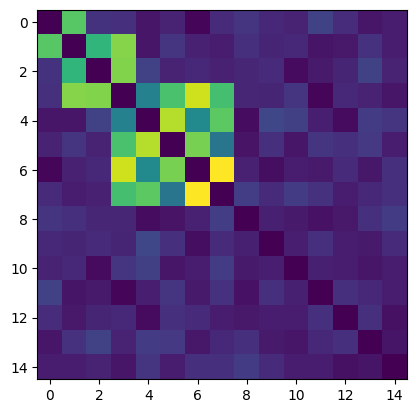

In [5]:
# Show the matrix
plt.imshow(contact_matrix, cmap='viridis', interpolation='nearest')

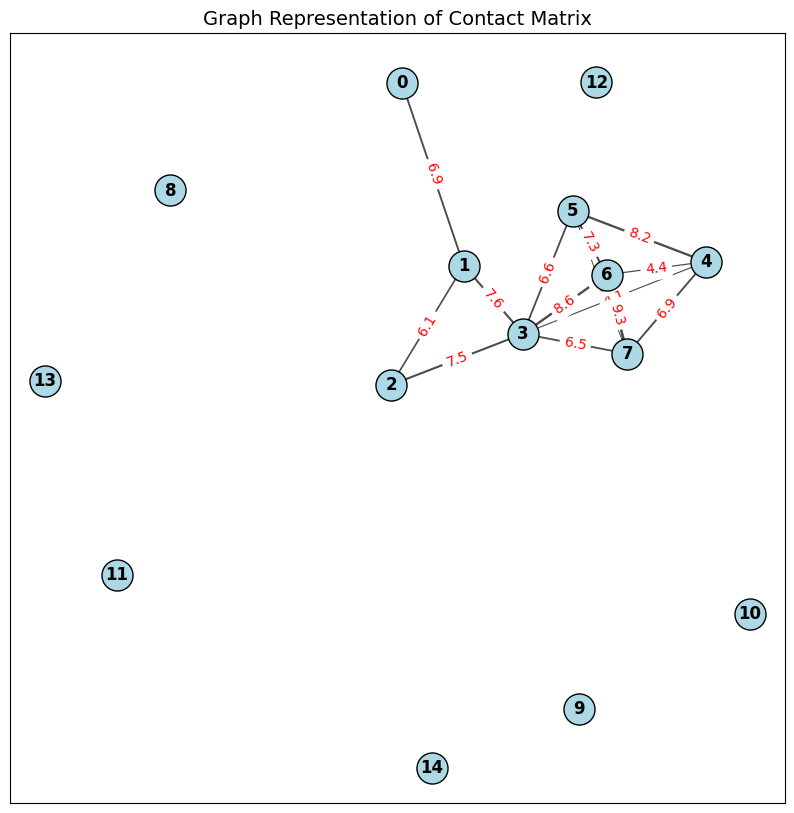

In [44]:

contact_matrix = f.generate_sample_matrix_bins(15)
graph = f.construct_graph_from_contact_matrix(contact_matrix, threshold=2)

In [47]:
def find_ttn_clique(graph,ttn_bin):
    cliques = list(nx.find_cliques(graph))

    sorted_cliques = sorted(cliques, key=len, reverse=True)

    # Step 3: Find the clique containing the TTN bin
    for clique in sorted_cliques:
        if ttn_bin in clique:
            return clique  # This is the clique containing the TTN bin

    return None  # Return None if no clique found (though unlikely)

In [48]:
ttn_bin = 1
ttn_clique = find_ttn_clique(graph, ttn_bin)
ttn_clique

[3, 1, 2]

In [50]:
def calculate_avg_interactions(graph, clique):
    interactions = 0
    for i in range(len(clique)):
        for j in range(i+1, len(clique)):
            interactions += graph[clique[i]][clique[j]]['weight']
    return interactions/len(clique)

In [54]:
ttn_clique_avg_interactions = calculate_avg_interactions(graph, ttn_clique)   
ttn_clique_avg_interactions

np.float64(7.054180249485782)

In [57]:
# Select 10 random bins to calculate the average interactions of the clique
